Description: this notebook uses the pretrained Vision Transformer (ViT) model found on Hugging Face:
https://huggingface.co/google/vit-base-patch16-224

The ViT model is pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. 

In this notebook, I explore performance on our family cat, which is apparently a surprisingly hard cat to identify



In [1]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-05-28 13:46:31.865989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Pre-trained Google / Hugging Face Model

In [2]:
# default download dir is ~/.cache/huggingface/hub
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/home/dm/miniconda3/envs/xformers/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
# default download dir is ~/.cache/huggingface/hub
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [4]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

# Check on Huggingface Data Example

Predicted class: Egyptian cat


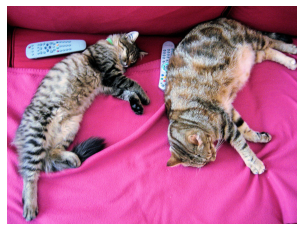

In [5]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
#show image
plt.figure()
plt.imshow(image)
plt.axis("off")
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

# Helper Function to Show Results

In [6]:
#set size of images used by model
image_size = (224,224)

def show_result(path):
    
    #load
    image = keras.preprocessing.image.load_img(path, target_size=image_size)
    
    #show image
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    
    #make predicitons and add to figure label
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    lbls = model.config.id2label[predicted_class_idx]
    plt.title(f"Predicted class: {lbls}")

    

# Checking on Kaggle / Microsoft Cats vs Dogs Data

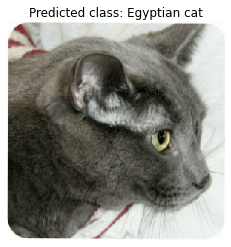

In [7]:
mydir = "/home/dm/ml_n_code/cats_vs_dogs/data/"
img_path = mydir+"train/Cat/6779.jpg"
show_result(img_path)

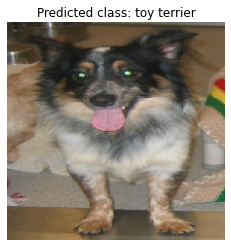

In [8]:
img_path = mydir+"train/Dog/6779.jpg"
show_result(img_path)

# Checking on Our Family's Turkish Van Cat

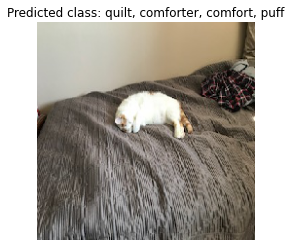

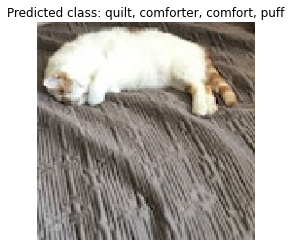

In [9]:
img_path = mydir+"test/Cat/2"+".jpg"
show_result(img_path)
img_path = mydir+"test/Cat/2e"+".jpg"
show_result(img_path)

/tmp/ipykernel_6941/2745868969.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


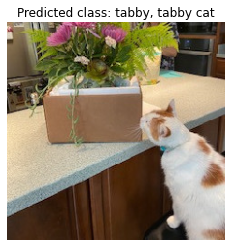

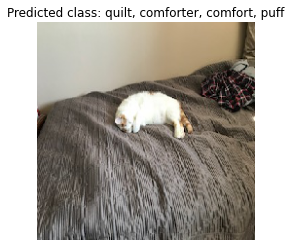

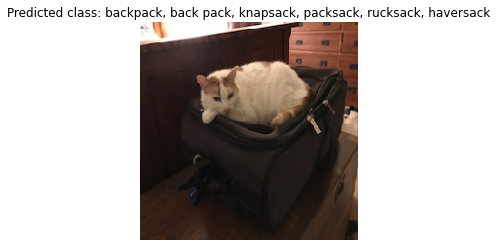

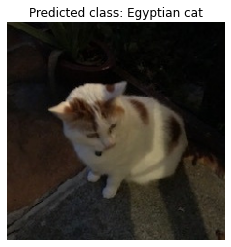

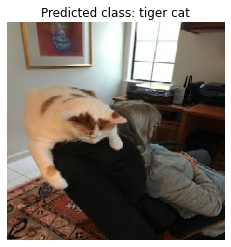

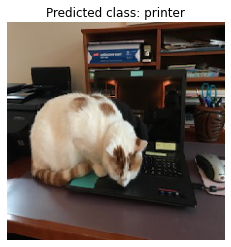

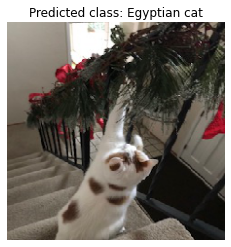

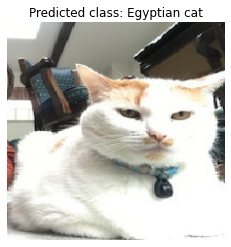

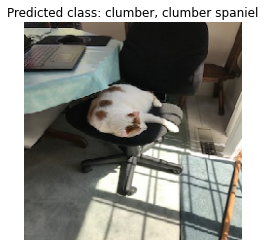

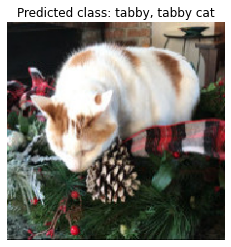

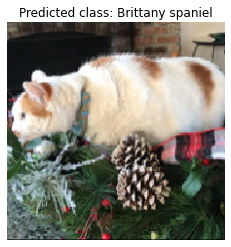

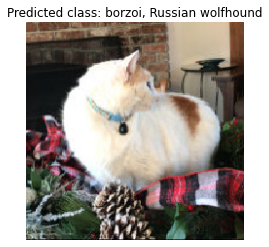

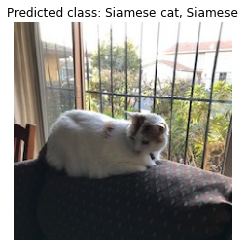

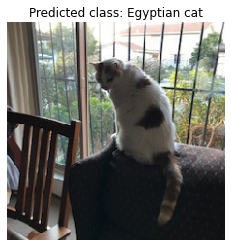

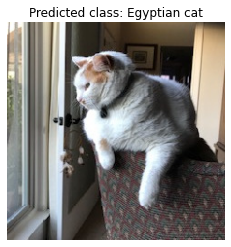

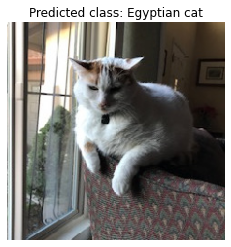

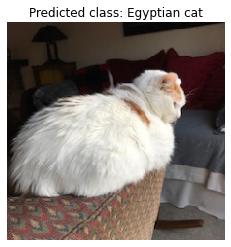

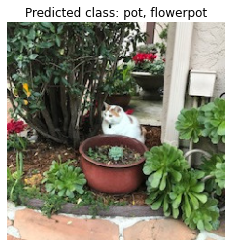

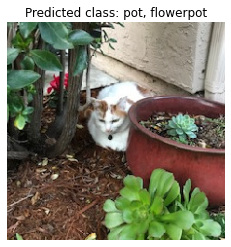

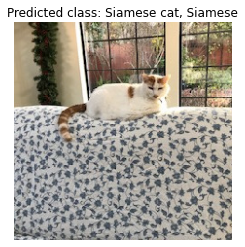

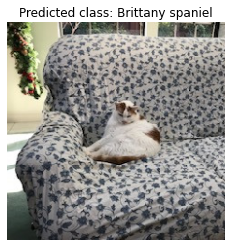

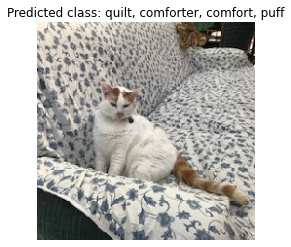

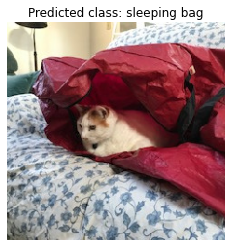

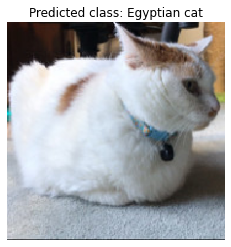

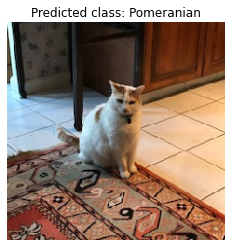

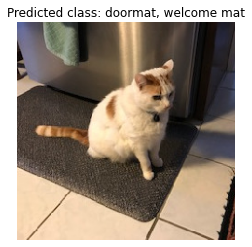

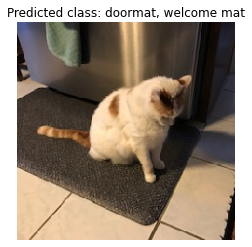

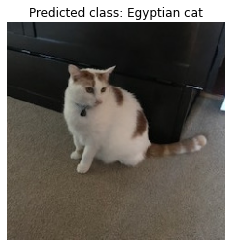

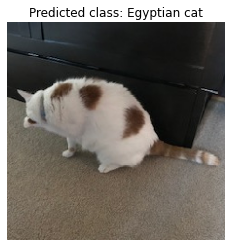

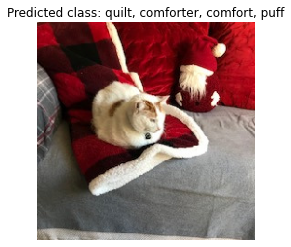

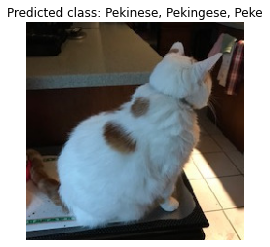

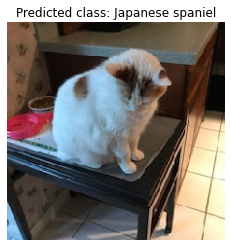

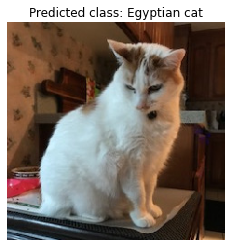

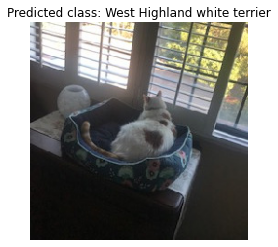

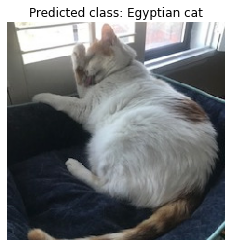

In [10]:
for ii in range(1,36):
    img_path = mydir+"test/Cat/"+str(ii)+".jpg"
    show_result(img_path)

In [11]:
# Results on our cat:
# 17 cat calls
# 8 dog calls
# 10 other calls (floormat, printer, etc.)


# Analysis

In [12]:
#observations (using what Carl Jung called "extroverted" or "objective sensing"):
#  1) Most dog calls correspond to dog breeds that are a similar color to our cat
#  2) Most cat calls correspond to cat breeds that are a different color to our cat
#  3) This is *not* a hierarchical classifier (i.e., it does not determine cat vs dog vs __ and then determine the 
#     subclass e.g., Egyptian cat vs Siamese cat vs __ cat like a human might reason)

#suspicion as to what is happening (using what Carl Jung called "introverted" or "subjective intuition"):
#     Since the classifier is not hierarchical, it may latch onto the shape of the animal and call it a random 
#     breed of cat, or instead latch onto the color and call it a dog breed of a similar color.  
#     Alternatively, the classifier may pay too much attention to other items in the image

#hypotheses: 
#  1) No Turkish Van or other cat colored like ours exists as an output class (and in the training data)
#  2) The classifier may be relying on color & color patterns more than is desirable



# Checking Hypothesis #1

In [13]:
# in linux terminal:
# cd ~/.cache/huggingface/hub/models--google--vit-base-patch16-224/blobs
# grep -i cat * | awk '{$1= ""; print $0}' #grep blobs to check for possible classes; pipe to awk to skip file name

# or equivalently here in notebook:
res = !grep -i cat ~/.cache/huggingface/hub/models--google--vit-base-patch16-224/blobs/* | awk '{$1= ""; print $0}'
res

['grep: /home/dm/.cache/huggingface/hub/models--google--vit-base-patch16-224/blobs/5f17067668129d23b52524f90a805e7d9914c276d90a59a13ebe81a09e40ceca: binary file matches',
 ' "ViTForImageClassification"',
 ' "30": "bullfrog, Rana catesbeiana",',
 ' "89": "sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita",',
 ' "143": "oystercatcher, oyster catcher",',
 ' "281": "tabby, tabby cat",',
 ' "282": "tiger cat",',
 ' "283": "Persian cat",',
 ' "284": "Siamese cat, Siamese",',
 ' "285": "Egyptian cat",',
 ' "286": "cougar, puma, catamount, mountain lion, painter, panther, Felis concolor",',
 ' "287": "lynx, catamount",',
 ' "358": "polecat, fitch, foulmart, foumart, Mustela putorius",',
 ' "361": "skunk, polecat, wood pussy",',
 ' "383": "Madagascar cat, ring-tailed lemur, Lemur catta",',
 ' "387": "lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens",',
 ' "484": "catamaran",',
 ' "688": "oscilloscope, scope, cathode-ray oscilloscope, CRO",',
 ' "Egyptian cat": 285,

In [14]:
# results are consistent with a web search of the classes, e.g., found here: 
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [15]:
# Conclusion: no Turkish Van colored cat exists as a class choice, supporting hypothesis #1

# next to do: finetune model to have just cat and just dog classes

# Checking on Friend's and Family's Dogs

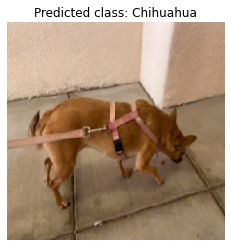

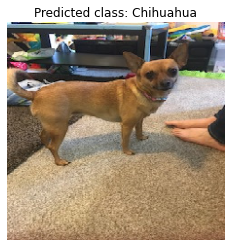

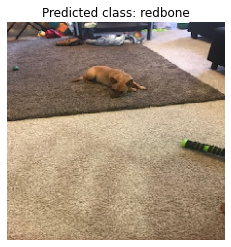

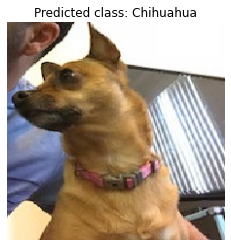

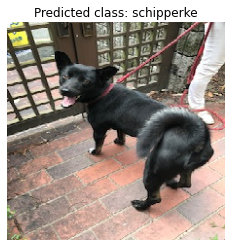

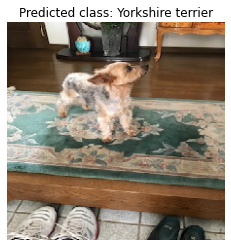

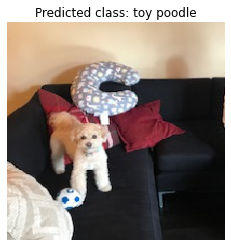

In [16]:
for ii in range(1,8):
    img_path = mydir+"test/Dog/"+str(ii)+".jpg"
    show_result(img_path)